In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

In [2]:
def imshow(img):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)

In [309]:
img = cv2.imread('2.jpg')

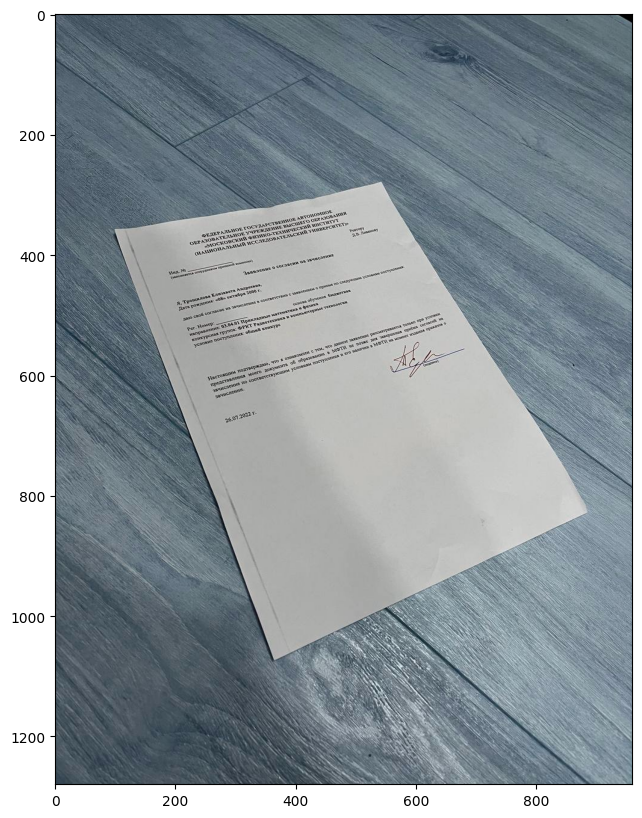

In [310]:
imshow(img)

In [311]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

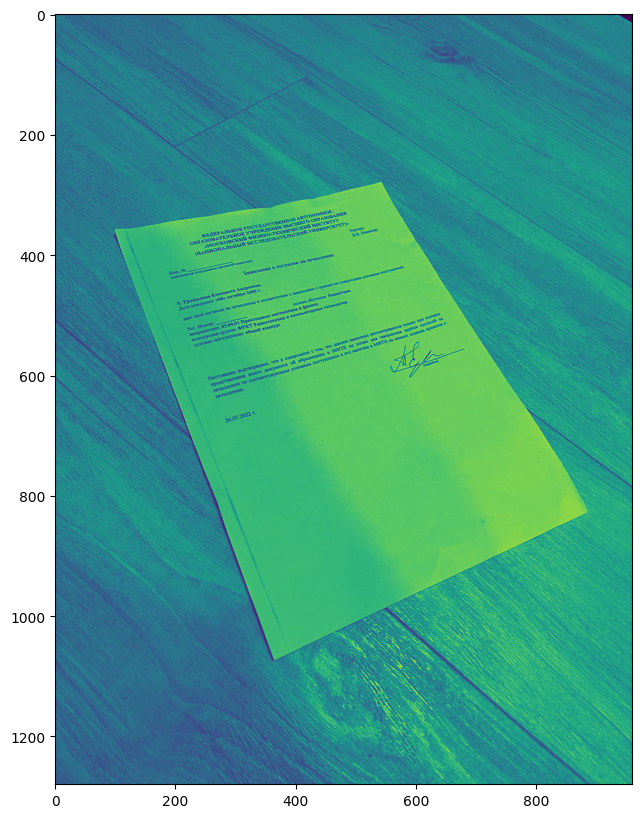

In [312]:
imshow(gray)

In [313]:
blur = cv2.GaussianBlur(gray, (11,11), 0)

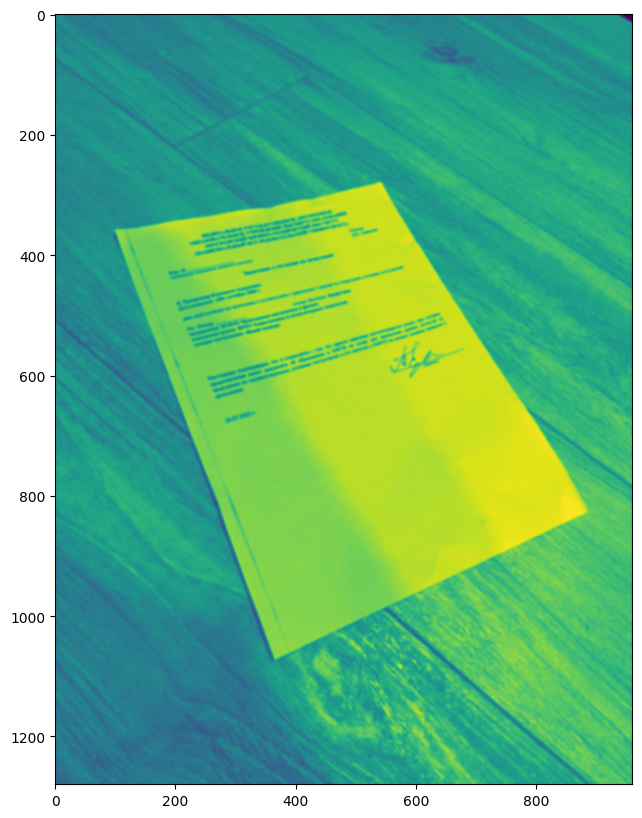

In [314]:
imshow(blur)

In [315]:
edge = cv2.Canny(blur, 0, 200)

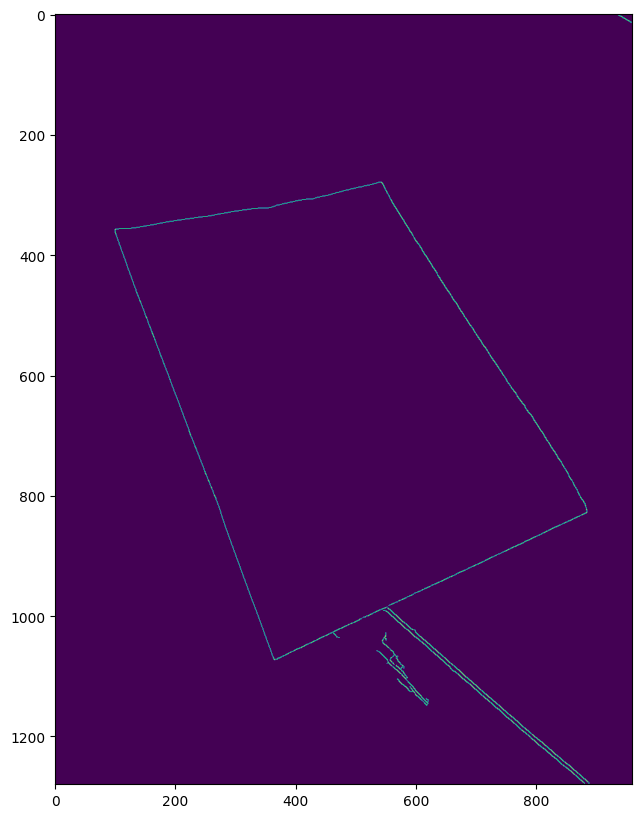

In [316]:
imshow(edge)

In [317]:
dilated = cv2.dilate(edge, np.ones((3, 3), dtype=np.uint8), iterations = 2)

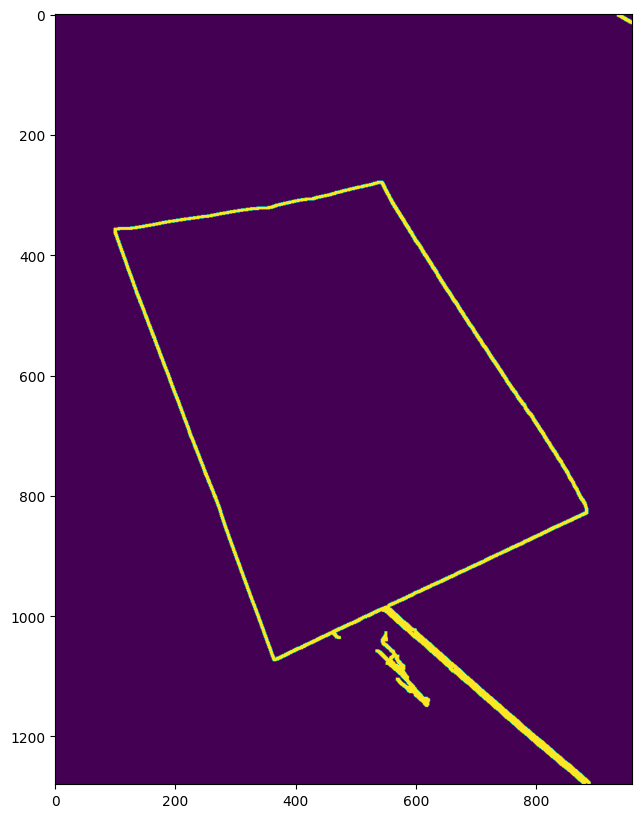

In [318]:
imshow(dilated)

In [319]:
contours, hierarchy = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

In [326]:
i = 0
len(contours)

9

8

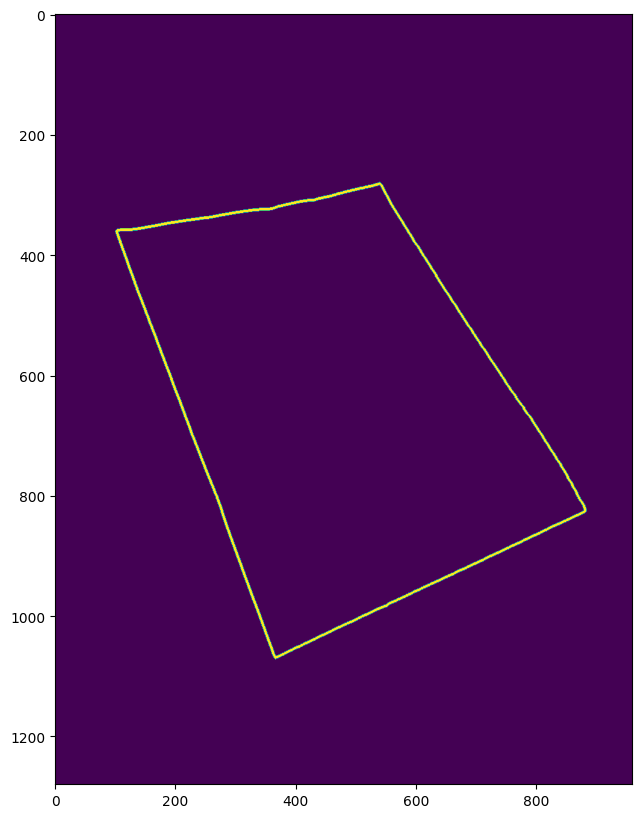

In [334]:
img_cp = np.zeros_like(edge, dtype=np.uint8)
cv2.drawContours(img_cp, contours[i:i+1], -1, 255, 3)
imshow(img_cp)
i += 1
i

In [281]:
from numpy import cross as cross2d

def hull_segment(vertices, i):
    first = i % vertices.shape[0]
    second = (i+1) % vertices.shape[0]
    return np.stack((vertices[first], vertices[second]))

def find_crossing_point(a, r1, b, r2):
    eps = 1e-4
    A = np.stack((a, -b)).T
    if np.abs(np.linalg.det(A)) >= eps:
        inv_A = np.linalg.inv(A)
        t = inv_A @ (r2 - r1)
        return True, t
    return False, np.array([0.0, 0.0], dtype=np.float64)

def quadr_area(p1, p2, p3, p4):
    a = p2 - p1
    b = p4 - p1
    c = p3 - p2
    d = p3 - p4
    return np.abs(cross2d(a, b)) / 2.0 + np.abs(cross2d(c, d)) / 2.0

def check_quadrilateral(p1, p2, p3, p4):
    norms = np.array([np.linalg.norm(x) for x in [p2-p1, p3-p2, p4-p3, p1-p4]])
    norms /= norms.min()
    return np.all(norms < 5)

def find_quadrilateral(vertices):
    segments = np.zeros((4, 2, 2))
    quadrs = []
    for i in range(vertices.shape[0]):
        segments[0] = hull_segment(vertices, i)
        a = segments[0][1] - segments[0][0]
        a /= np.linalg.norm(a)
        r1 = segments[0][0]
        for j in range(i+1, vertices.shape[0]):
            segments[1] = hull_segment(vertices, j)
            b = segments[1][1] - segments[1][0]
            b /= np.linalg.norm(b)
            r2 = segments[1][0]
            for k in range(j+1, vertices.shape[0]):
                segments[2] = hull_segment(vertices, k)
                c = segments[2][1] - segments[2][0]
                c /= np.linalg.norm(c)
                r3 = segments[2][0]
                for m in range(k+1, vertices.shape[0]):
                    segments[3] = hull_segment(vertices, m)
                    d = segments[3][1] - segments[3][0]
                    d /= np.linalg.norm(d)
                    r4 = segments[3][0]

                    res_ok_1, t1 = find_crossing_point(b, r2, a, r1)
                    res_ok_2, t2 = find_crossing_point(c, r3, b, r2)
                    res_ok_3, t3 = find_crossing_point(d, r4, c, r3)
                    res_ok_4, t4 = find_crossing_point(a, r1, d, r4)

                    if res_ok_1 and t1[0] < 0 and t1[1] > 0 and \
                       res_ok_2 and t2[0] < 0 and t2[1] > 0 and \
                       res_ok_3 and t3[0] < 0 and t3[1] > 0 and \
                       res_ok_4 and t4[0] < 0 and t4[1] > 0:

                        p1 = r1 + a * t1[1]
                        p2 = r2 + b * t2[1]
                        p3 = r3 + c * t3[1]
                        p4 = r4 + d * t4[1]
                        # if check_quadrilateral(p1, p2, p3, p4):
                        quadrs.append([p1, p2, p3, p4])

    return quadrs

def find_lowest_area_quadrilateral(quadrs):
    k = -1
    s = -1.0
    for i, (p1, p2, p3, p4) in enumerate(quadrs):
        new_s = quadr_area(p1, p2, p3, p4)
        if s == -1.0:
            s = new_s
            k = i
        elif new_s < s:
            s = new_s
            k = i
    return k

def order_points(pts):
    
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped


In [350]:
im_area = img.shape[0] * img.shape[1]
q_shapes = []

for i in range(len(contours)):
    cont = contours[i].reshape((contours[i].shape[0], 2))
    hull = ConvexHull(cont, incremental=False)

    hull_points = cont[hull.vertices]
    quadrs = np.array(find_quadrilateral(hull_points.astype(np.float64)))

    if quadrs.shape[0] > 0:
        j = find_lowest_area_quadrilateral(quadrs)
        q = quadrs[j]

        q_area = quadr_area(q[0], q[1], q[2], q[3])
        c_area = cv2.contourArea(cont)

        if c_area / im_area > 0.2 and c_area / q_area > 0.9:
            print(i)
            q_shapes.append(q)

7


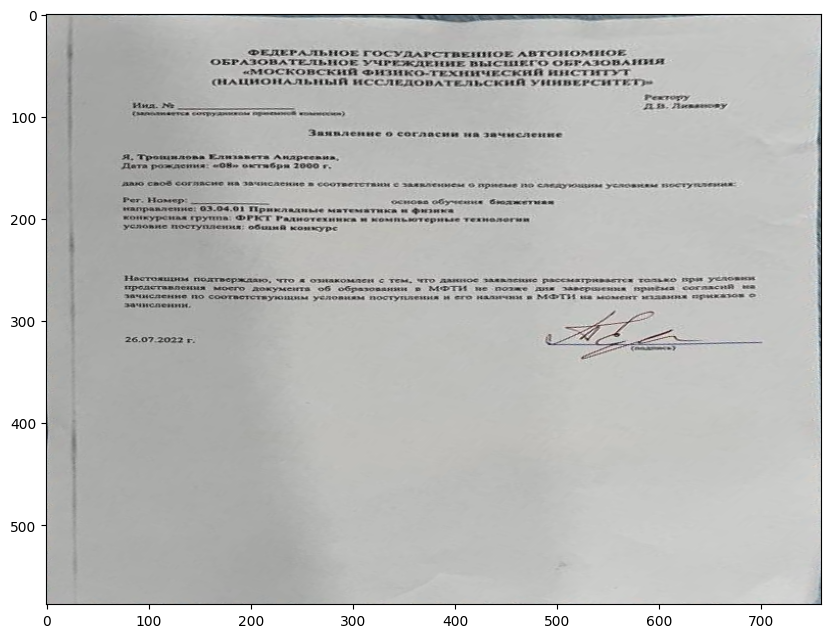

In [356]:
fig, ax = plt.subplots(figsize=(10 * len(q_shapes), 10), nrows=len(q_shapes))

for i, q in enumerate(q_shapes):
    transformed_img = four_point_transform(img.astype(np.uint8), q.astype(np.float32))
    if len(q_shapes) > 1:
        ax[i].imshow(transformed_img)
    else:
        ax.imshow(transformed_img)